In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import arviz
import pathlib
from matplotlib import animation

In [52]:
sns.set_context("talk")
%config InlineBackend.figure_format = 'retina'
##plt.style.use('arviz-darkgrid')
sns.set_style("darkgrid")

In [53]:
ds = xr.open_dataset("benchmarks.nc")

In [54]:
eff = ds.grad_evals_per_ess
np.exp(np.log((eff.sel(sampler_name="cmdstanpy") / eff)).mean(["model_name"]))

<xarray.DataArray 'grad_evals_per_ess' (machine: 1, sampler_name: 4)> Size: 32B
array([[1.        , 1.63672218, 1.73758778, 1.99545211]])
Coordinates:
  * sampler_name  (sampler_name) <U24 384B 'cmdstanpy' ... 'nutpie-stan-600'
  * machine       (machine) <U3 12B 'r7a'

Text(0.5, 0.98, 'nutpie is 2x faster on average')

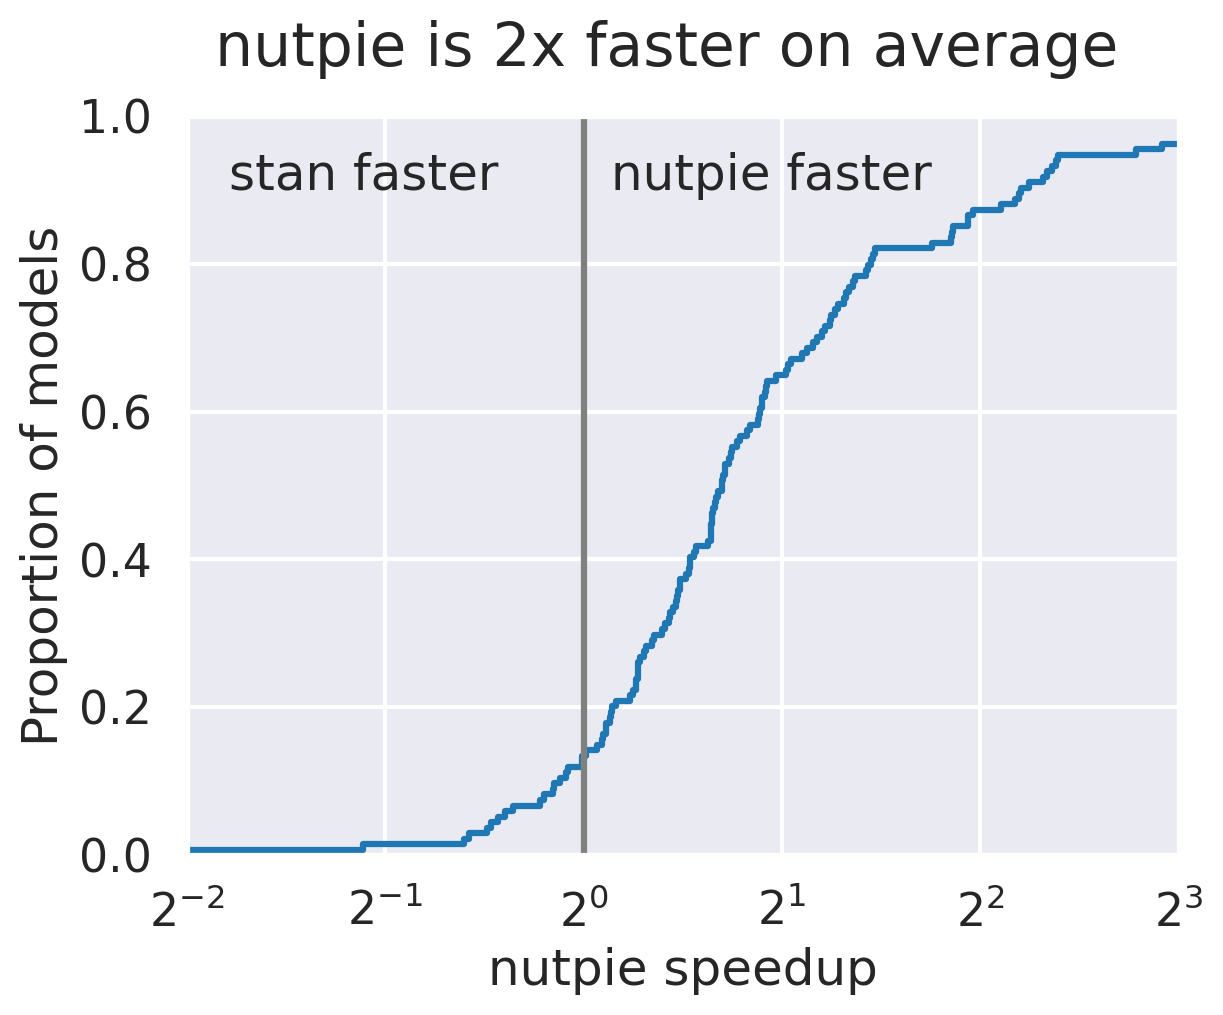

In [14]:
#bad = (ds.min_effective_draws < 500) | (ds.divergences > 0)
#ds = ds.sel(model_name=~bad.all(["sampler_name", "machine"]))
fig = plt.figure()
ds_ = ds.sel(model_name=ds.wall_time.min(["machine", "sampler_name"]) > 0)
ds["speedup"] = ds_.seconds_per_ess.sel(sampler_name="cmdstanpy") / ds.seconds_per_ess

sns.ecdfplot(ds.speedup.sel(sampler_name="nutpie-stan-1000", machine="r7a").values)
plt.xscale("log", base=2)
plt.axvline(1, color="gray")
plt.xlim(2**(-2), 2**3)
plt.xlabel("nutpie speedup")
plt.ylabel("Proportion of models")
#plt.title("ecdf plot of nutpie speedups")
plt.annotate("nutpie faster", (1.1, 0.9))
plt.annotate("stan faster", (0.29, 0.9))
fig.suptitle("nutpie is 2x faster on average")

In [36]:
ds

<xarray.Dataset> Size: 104kB
Dimensions:                  (model_name: 136, sampler_name: 4, machine: 1)
Coordinates:
  * model_name               (model_name) <U59 32kB 'GLMM_Poisson_data-GLMM_P...
  * sampler_name             (sampler_name) <U24 384B 'cmdstanpy' ... 'nutpie...
  * machine                  (machine) <U3 12B 'r7a'
Data variables: (12/16)
    wall_time                (model_name, sampler_name, machine) float64 4kB ...
    process_time             (model_name, sampler_name, machine) float64 4kB ...
    float32                  (model_name, sampler_name, machine) float64 4kB ...
    device                   (model_name, sampler_name, machine) <U3 7kB ...
    min_effective_draws      (model_name, sampler_name, machine) float64 4kB ...
    max_effective_draws      (model_name, sampler_name, machine) float64 4kB ...
    ...                       ...
    acceptance_rate_geomean  (model_name, sampler_name, machine) float64 4kB ...
    divergences              (model_name, sampler_name, machine) float64 4kB ...
    warmup_grad_evals        (model_name, sampler_name, machine) float64 4kB ...
    seconds_per_ess          (model_name, sampler_name, machine) float64 4kB ...
    grad_evals_per_ess       (model_name, sampler_name, machine) float64 4kB ...
    speedup                  (model_name, machine, sampler_name) float64 4kB ...

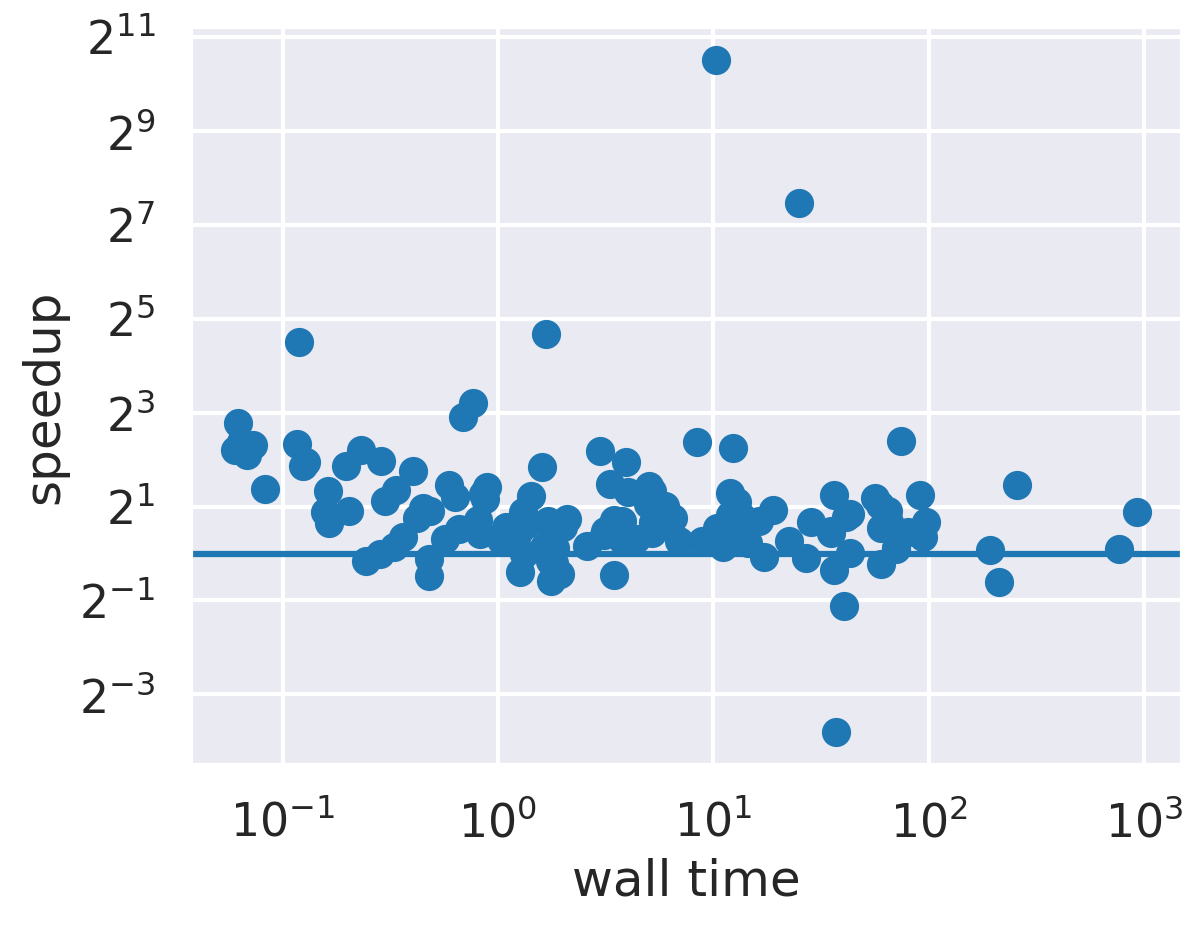

In [34]:
plt.scatter((ds.wall_time.sel(sampler_name="cmdstanpy", machine="r7a")), ds.speedup.sel(sampler_name="nutpie-stan-1000", machine="r7a"))
plt.yscale("log", base=2)
plt.xscale("log", base=10)
plt.xlabel("wall time")
plt.ylabel("speedup")
#plt.axhline(0)
plt.axhline(1)
#plt.ylim(0.1, 6)

In [55]:
base = pathlib.Path("/mnt/harddrives/data/pymc-labs/samplerlab/traces-stan-R7a-xlarge/traces-stan/2024-07-31T134259/")

base = base / "radon_all-radon_variable_intercept_slope_noncentered"

stan = arviz.from_zarr(str(base / "cmdstanpy-cpu" / "trace.zarr")).load()
nutpie = arviz.from_zarr(str(base / "nutpie-stan-1000-cpu" / "trace.zarr")).load()

bias_stan = (stan.posterior.mean(["draw", "chain"]) - stan.warmup_posterior) / stan.posterior.std(["draw", "chain"])
bias_nutpie = (nutpie.posterior.mean(["draw", "chain"]) - nutpie.warmup_posterior) / nutpie.posterior.std(["draw", "chain"])

subs = dict(draw=slice(None, 500), chain=0)

plt.plot(stan.warmup_sample_stats.n_steps.cumsum().isel(**subs), bias_stan.sigma_y.isel(**subs) ** 2, color="C1", label="stan");
plt.plot(nutpie.warmup_sample_stats.n_steps.cumsum().isel(**subs), bias_nutpie.sigma_y.isel(**subs) ** 2, color="C0", label="nutpie");
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Gradient evaluations")
plt.ylabel("Bias")
plt.title("Bias in radon model")
plt.xlim(10, None)

ImportError: 'to_zarr' method needs Zarr (2.5.0+) installed.

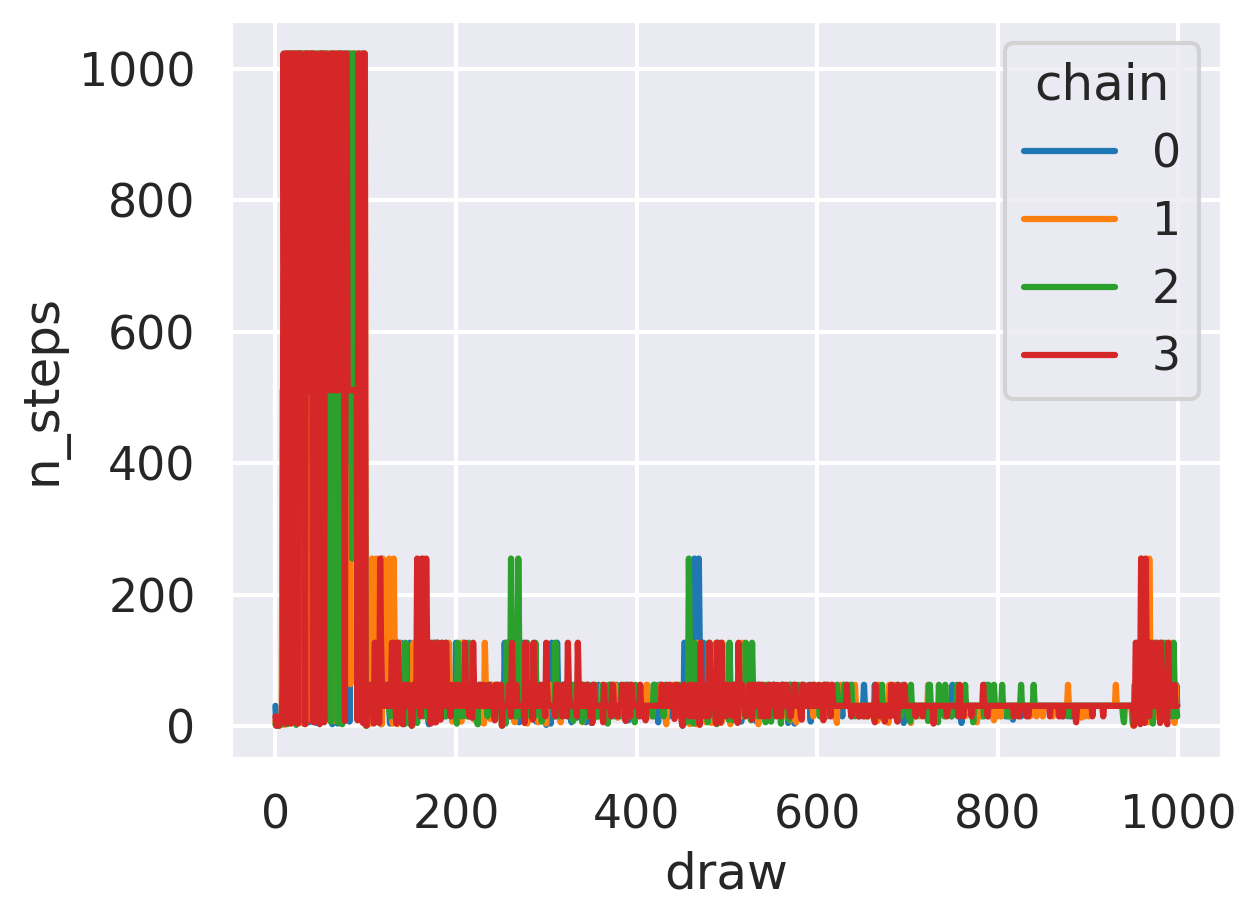

In [39]:
stan.warmup_sample_stats.n_steps.plot.line(x="draw")

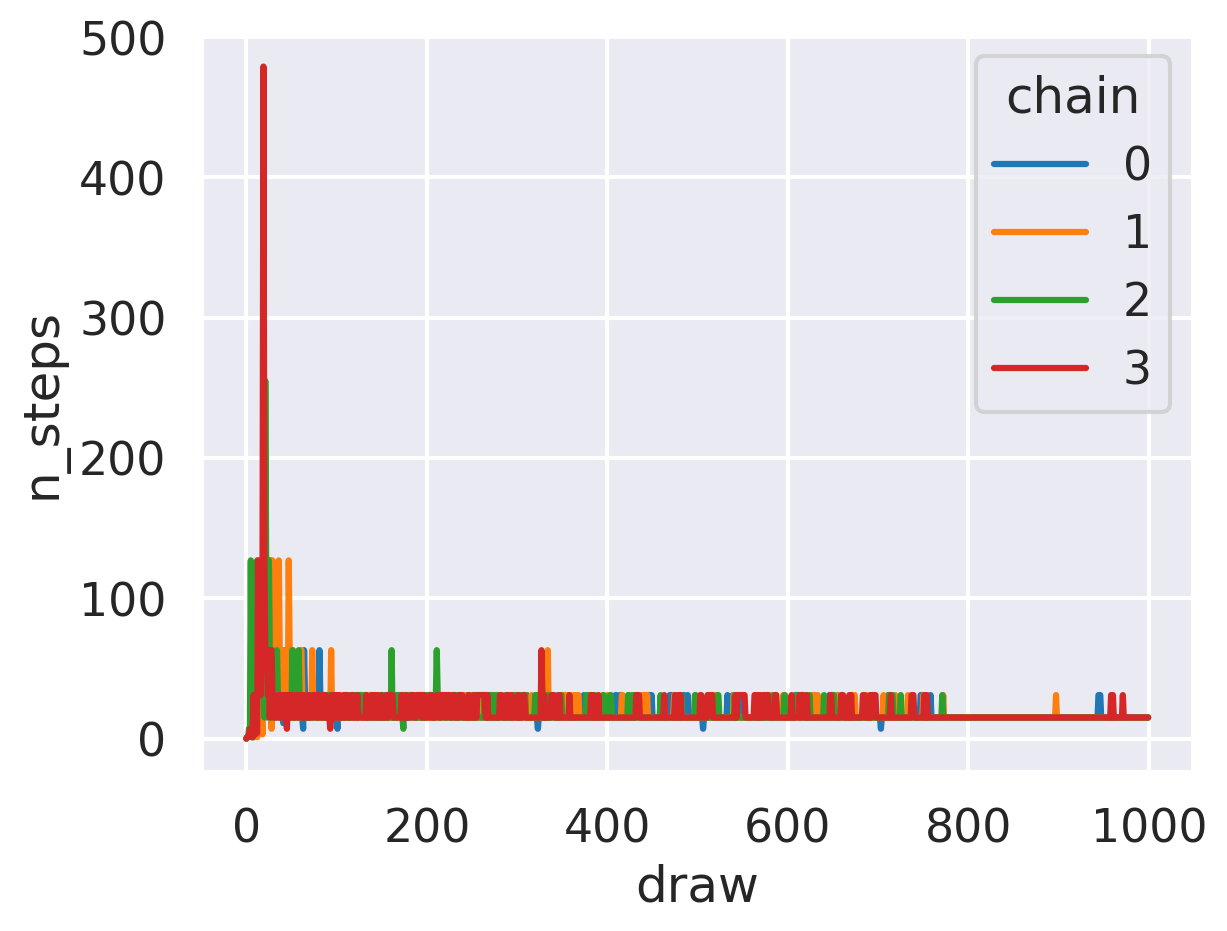

In [40]:
nutpie.warmup_sample_stats.n_steps.plot.line(x="draw")

In [41]:
cov = np.array([[1., 0.96], [0.96, 1.]])
cov[:, 0] /= 6
cov[0, :] /= 6

prec = np.linalg.inv(cov)

draws = np.random.multivariate_normal(mean=np.zeros(len(cov)), cov=cov, size=500)
grads = -(prec @ draws.T).T

draws = draws[:, :2]
grads = grads[:, :2]

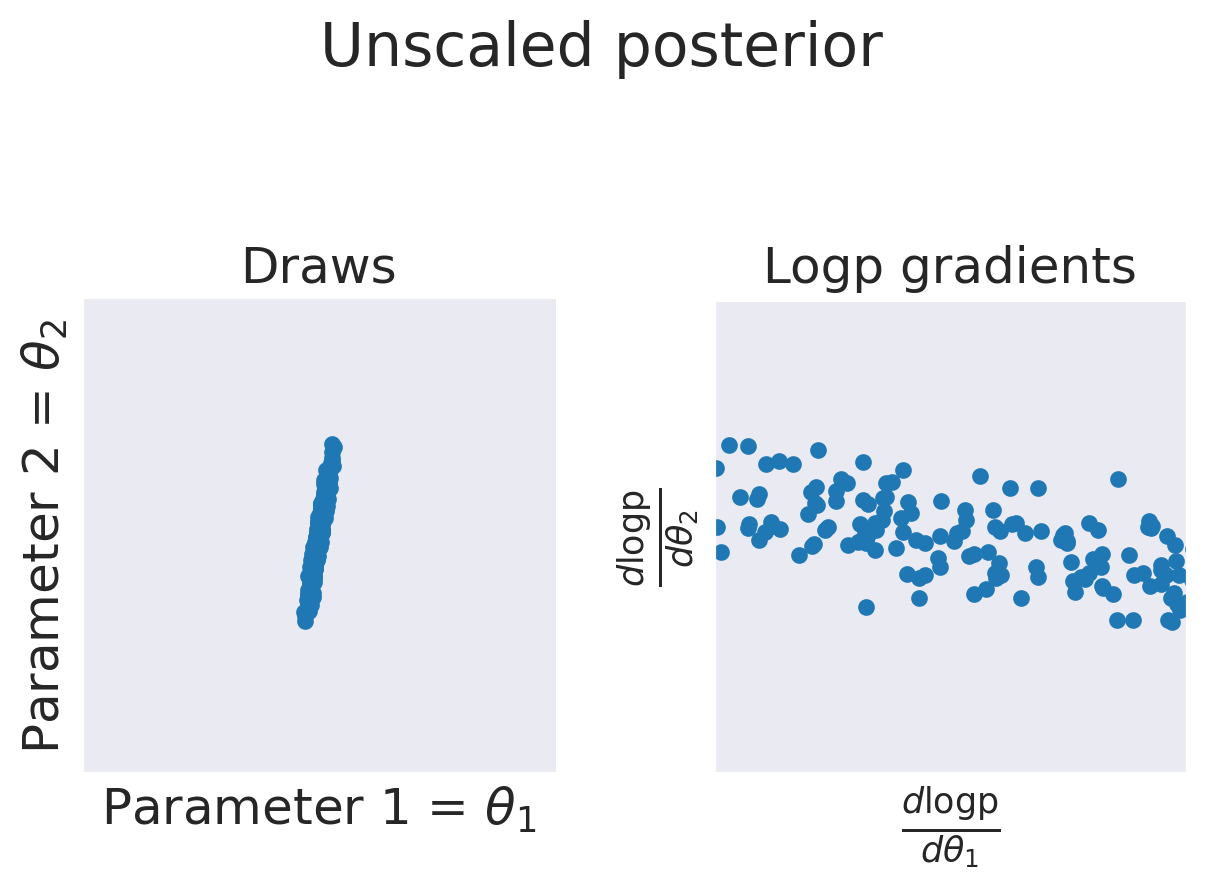

In [42]:
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1, aspect="equal")

sns.despine(fig=fig)

lim = 8

ax.scatter(*draws.T, marker=".")
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Draws")
ax.set_xlabel(r"Parameter 1 = $\theta_1$")
ax.set_ylabel(r"Parameter 2 = $\theta_2$")

#sns.despine(top=True, right=True, left=True, bottom=True, ax=ax)
#ax.plot(*np.array([(-2, -3), (2, -3)]).T, color="black", marker="|")
#ax.annotate("1", xy=(0., -3), xytext=(-0.5, -5),)

ax = fig.add_subplot(1, 2, 2, aspect="equal")
ax.scatter(*grads.T, marker=".")
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_xlabel(r"$\frac{d\text{logp}}{d\theta_1}$")
ax.set_ylabel(r"$\frac{d\text{logp}}{d\theta_2}$")

#sns.despine(top=True, right=True, left=True, bottom=True, fig=fig)
ax.set_xticks([])
ax.set_yticks([])

ax.set_title("Logp gradients")
fig.suptitle("Unscaled posterior")
fig.tight_layout()


In [43]:
scale_stan = np.sqrt(np.diag(cov))[:2]
draws_stan = draws / scale_stan
grads_stan = grads * scale_stan

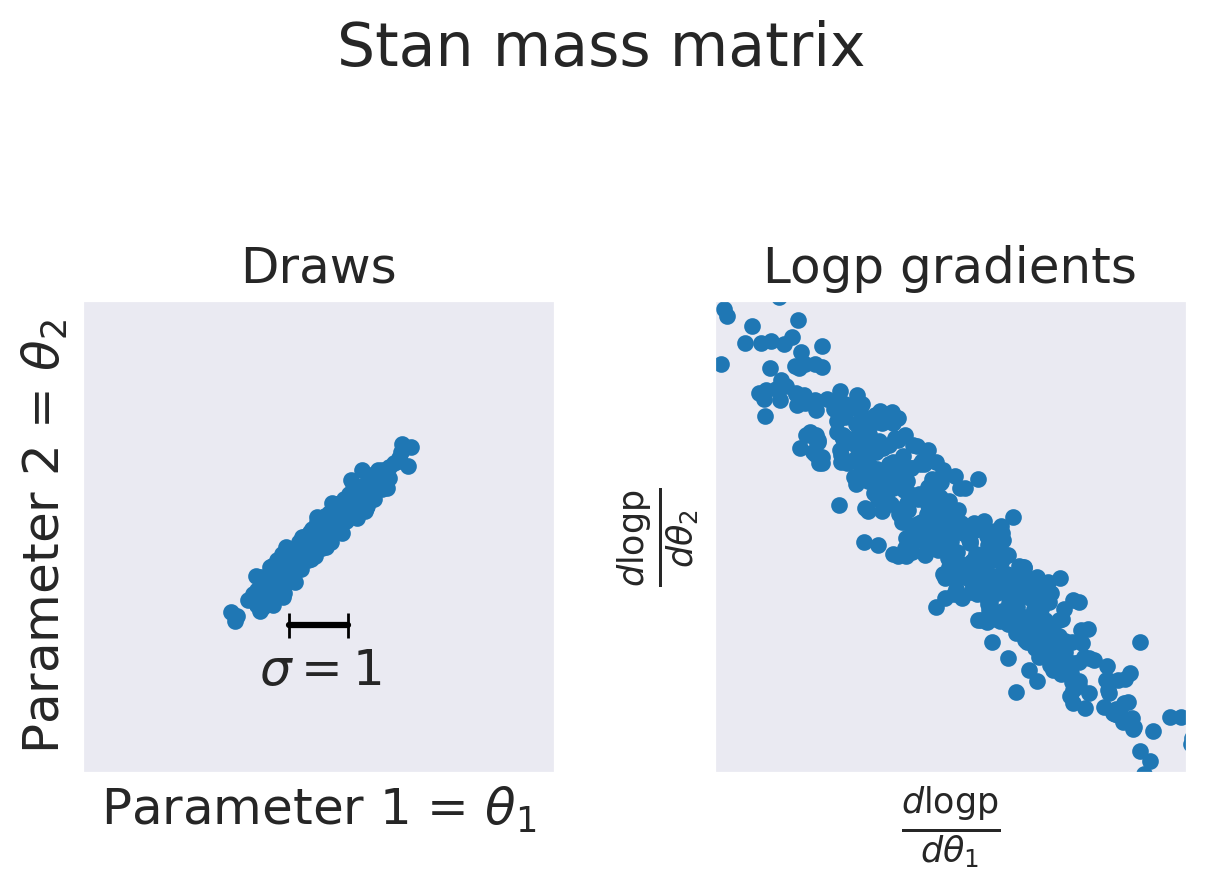

In [44]:
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1, aspect="equal")

lim = 8

ax.scatter(*draws_stan.T, marker=".")
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Draws")
ax.set_xlabel(r"Parameter 1 = $\theta_1$")
ax.set_ylabel(r"Parameter 2 = $\theta_2$")


ax.plot(*np.array([(-1, -3), (1, -3)]).T, color="black", marker="|")
ax.annotate(r"$\sigma = 1$", xy=(0., -3), xytext=(-2, -5),)

ax = fig.add_subplot(1, 2, 2, aspect="equal")
ax.scatter(*grads_stan.T, marker=".")
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel(r"$\frac{d\text{logp}}{d\theta_1}$")
ax.set_ylabel(r"$\frac{d\text{logp}}{d\theta_2}$")

#ax.plot(line_x, line_y, marker='|', color='red', markersize=20, linewidth=2, label='Length = 1')

ax.set_title("Logp gradients")
fig.suptitle("Stan mass matrix")
fig.tight_layout()


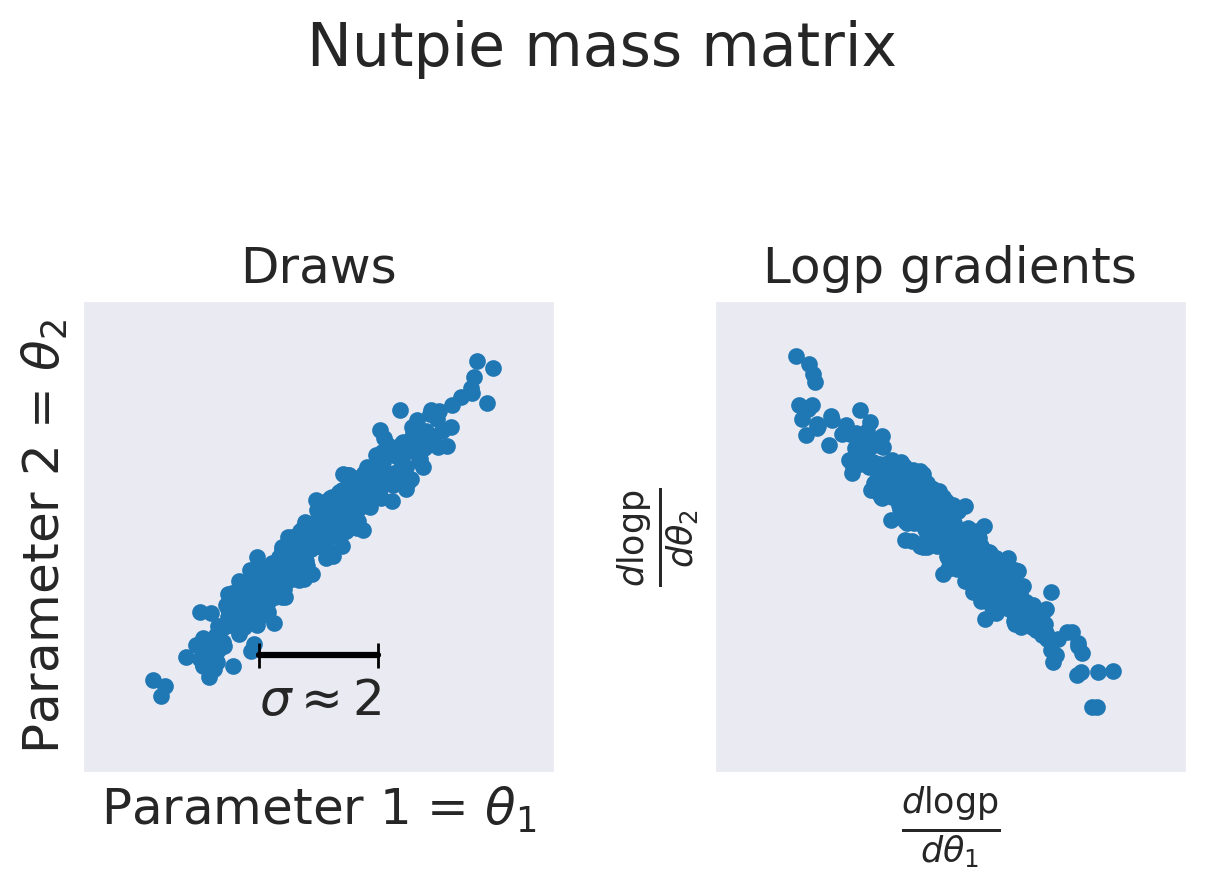

In [45]:
scale_grads = np.sqrt(np.sqrt(np.diag(cov)) / np.sqrt(np.diag(prec)))[:2]
draws_grads = draws / scale_grads
grads_grads = grads * scale_grads

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1, aspect="equal")

lim = 8

ax.scatter(*draws_grads.T, marker=".")
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel(r"Parameter 1 = $\theta_1$")
ax.set_ylabel(r"Parameter 2 = $\theta_2$")

ax.plot(*np.array([(-2, -4), (2, -4)]).T, color="black", marker="|")
ax.annotate(r"$\sigma \approx 2$", xy=(0., -4), xytext=(-2, -6),)

ax.set_title("Draws")

ax = fig.add_subplot(1, 2, 2, aspect="equal")
ax.scatter(*grads_grads.T, marker=".")
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel(r"$\frac{d\text{logp}}{d\theta_1}$")
ax.set_ylabel(r"$\frac{d\text{logp}}{d\theta_2}$")

ax.set_title("Logp gradients")
fig.suptitle("Nutpie mass matrix")
fig.tight_layout()


In [46]:
print((np.log(np.linalg.eigvalsh(np.cov(draws_stan.T))) ** 2).sum())
print((np.log(np.linalg.eigvalsh(np.cov(draws_grads.T))) ** 2).sum())

11.140190826831574
8.285861867911965


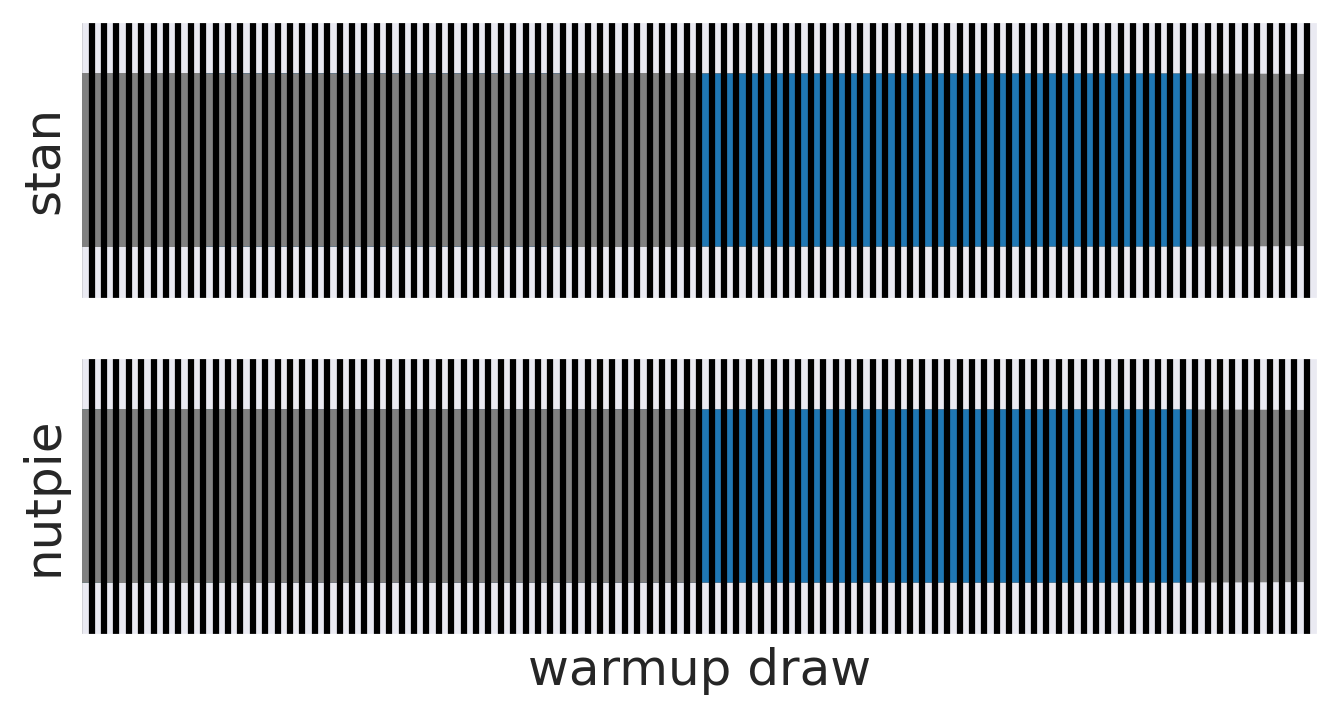

In [30]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 4))


frames = []

# figsize keyword talks some obscure units which need a conversion from standard units
#fig = plt.figure(figsize=np.array([210,297]) / 25.4)

#ax1.set_position([0, 0.5, 1, 0.5])
ax1.set_xticks([])
ax1.set_yticks([])

#ax2.set_position([0, 0, 1, 0.5])
ax2.set_xticks([])
ax2.set_yticks([])

ax1.set_ylabel("stan")
ax2.set_ylabel("nutpie")

ax1.set_xlim(0, 100)
ax1.set_ylim(0, 1)
ax2.set_xlim(0, 100)
ax2.set_ylim(0, 1)

ax2.set_xlabel("warmup draw")

def rect(ax, frame, x, y, *, color="C0"):
    #return plt.Rectangle((x, 0.35), y - x, 0.45, facecolor=color, edgecolor=color)
    artist = plt.Rectangle((x, 0.2), y - x, 0.6, facecolor=color, edgecolor=color)
    frame.append(ax.add_artist(artist))
    

def rect_step(ax, frame, x, y, *, color="C1"):
    #return plt.Rectangle((x, 0.2), y - x, 0.15, facecolor=color, edgecolor=color)
    pass

frames = []
for i in range(100):
    frame = []

    rect(ax2, frame, 0, i, color="gray")
    rect(ax1, frame, 0, i, color="gray")

    rect_step(ax2, frame, 0, i, color="gray")
    rect_step(ax1, frame, 0, i, color="gray")

    frame.append(ax1.axvline(i, color="black"))
    #frame.append(ax1.hlines(0.35, 0, i, color="black"))

    if i < 10:
        rect_step(ax1, frame, 0, i)
    elif i < 40:
        rect_step(ax1, frame, 0, 10)
    elif i < 50:
        rect(ax1, frame, 10, 40)
        rect_step(ax1, frame, 40, i)
    elif i < 90:
        rect(ax1, frame, 10, 40)
        rect_step(ax1, frame, 40, 50)
    else:
        rect(ax1, frame, 50, 90)
        rect_step(ax1, frame, 90, i)

    frame.append(ax2.axvline(i, color="black"))
    #frame.append(ax2.hlines(0.35, 0, i, color="black"))

    if i < 10:
        rect(ax2, frame, 0, i)
    elif i < 15:
        rect(ax2, frame, 5, i)
    elif i < 20:
        rect(ax2, frame, 10, i)
    elif i < 50:
        rect(ax2, frame, 15, i)
    elif i < 80:
        rect(ax2, frame, 30, i)
    elif i < 90:
        rect(ax2, frame, 50, i)
    else:
        rect(ax2, frame, 50, 90)

    if i < 20:
        rect_step(ax2, frame, 0, i)
    else:
        rect_step(ax2, frame, 50, i)

    frames.append(frame)

In [33]:
ani = animation.ArtistAnimation(fig=fig, artists=frames, interval=400)
ani.save(
    filename="plots/early_adapt2.gif",
    writer="pillow",
    savefig_kwargs=dict(transparent=True, facecolor=(1, 1, 1, 0), edgecolor=(1, 1, 1, 0)),
    dpi=400,
    fps=8,
)